Q2. Find top 10 studio with their the revenue ratio every year.

Hypothesis: make more movie can make more profit & acquire small studios

In [2]:
import pandas as pd
import numpy as np
import requests as rq
import sqlite3
from sklearn.preprocessing import OneHotEncoder
from zipfile import ZipFile
import tarfile
import gzip
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x * 1e-6)

def billions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fB' % (x * 1e-9)

1. Unzip & import Dataframes

In [3]:
with gzip.open("zippedData/bom.movie_gross.csv.gz", "rb") as f:
    bom_movie_gross = pd.read_csv(f)

with gzip.open("zippedData/tmdb.movies.csv.gz", "rb") as f:
    tmdb_movies = pd.read_csv(f)

with gzip.open("zippedData/tn.movie_budgets.csv.gz", "rb") as f:
    tn_movie_budgets = pd.read_csv(f)


2. Setting Dataframs' index to 'title'

In [4]:
bom_movie_gross.set_index('title', inplace=True)

tn_movie_budgets = tn_movie_budgets.rename(columns={'movie':'title'})
tn_movie_budgets.set_index('title', inplace=True)

tmdb_movies.set_index('title', inplace=True)
tmdb_movies = tmdb_movies.drop(['id', 'Unnamed: 0', 'original_language', 'original_title', 'genre_ids'], axis=1)

3. Join Dataframes

In [5]:
movie_budget = tn_movie_budgets.join(bom_movie_gross, how='outer', rsuffix='_bom')
movie_budget_pop = movie_budget.join(tmdb_movies, how='outer', rsuffix='_pop')

4. Data cleaning

In [6]:
# remove dollar sign
movie_budget_pop.domestic_gross[movie_budget_pop.domestic_gross.str[0] == "$"] = movie_budget_pop.domestic_gross.str[1:]
movie_budget_pop.production_budget[movie_budget_pop.production_budget.str[0] == "$"] = movie_budget_pop.production_budget.str[1:]
movie_budget_pop.worldwide_gross[movie_budget_pop.worldwide_gross.str[0] == "$"] = movie_budget_pop.worldwide_gross.str[1:]


# remove ',' sign
movie_budget_pop['production_budget'] = movie_budget_pop['production_budget'].str.replace(',','', regex=True)
movie_budget_pop['domestic_gross'] = movie_budget_pop['domestic_gross'].str.replace(',','', regex=True)
movie_budget_pop['worldwide_gross'] = movie_budget_pop['worldwide_gross'].str.replace(',','', regex=True)
movie_budget_pop['foreign_gross'] = movie_budget_pop['foreign_gross'].str.replace(',','', regex=True)


# rename studio column values
movie_budget_pop['studio'] = movie_budget_pop['studio'].str.replace('FoxS','Fox', regex=True)
movie_budget_pop['studio'] = movie_budget_pop['studio'].str.replace("WB (NL)","WB", regex=False)


# change 'domestic_gross_bom' type to str
movie_budget_pop['domestic_gross_bom'] = movie_budget_pop['domestic_gross_bom'].astype('str')


# remove .00 from year
movie_budget_pop['year'] = movie_budget_pop['year'].astype('str')
movie_budget_pop.domestic_gross_bom = movie_budget_pop.domestic_gross_bom.str[0:-2]
movie_budget_pop.year = movie_budget_pop.year.str[0:-2]


# fill NaN values
movie_budget_pop['domestic_gross'] = movie_budget_pop['domestic_gross'].fillna(movie_budget_pop['domestic_gross_bom'])
movie_budget_pop['domestic_gross_bom'] = movie_budget_pop['domestic_gross_bom'].fillna(0)
movie_budget_pop.domestic_gross_bom[movie_budget_pop.domestic_gross_bom == "n"] = 0

movie_budget_pop.foreign_gross[movie_budget_pop.foreign_gross.str[-2] == "."] = movie_budget_pop.foreign_gross.str[0:-2]
movie_budget_pop['foreign_gross'] = movie_budget_pop['foreign_gross'].fillna(0)
movie_budget_pop['domestic_gross_bom'] = movie_budget_pop['domestic_gross_bom'].astype('int')
movie_budget_pop['foreign_gross'] = movie_budget_pop['foreign_gross'].astype('int')
movie_budget_pop['new_total'] = movie_budget_pop['domestic_gross_bom'] + movie_budget_pop['foreign_gross']

movie_budget_pop.new_total[movie_budget_pop.new_total == 0] = np.nan
movie_budget_pop['new_total'] = movie_budget_pop['new_total'].astype('str')

movie_budget_pop['worldwide_gross'] = movie_budget_pop['worldwide_gross'].fillna(movie_budget_pop['new_total'])
movie_budget_pop.worldwide_gross[movie_budget_pop.worldwide_gross.str[-2] == "."] = movie_budget_pop.worldwide_gross.str[0:-2]
movie_budget_pop.worldwide_gross[movie_budget_pop.worldwide_gross == '0'] = np.nan
movie_budget_pop.dropna(subset=['production_budget', 'worldwide_gross'], inplace=True)

movie_budget_pop.year[movie_budget_pop.year == "n"] = np.nan
movie_budget_pop['rel_year'] = movie_budget_pop['release_date'].str[-4:]
movie_budget_pop['rel_year2'] = movie_budget_pop['release_date_pop'].str[:4]

movie_budget_pop['year'] = movie_budget_pop['year'].fillna(movie_budget_pop['rel_year'])
movie_budget_pop['year'] = movie_budget_pop['year'].fillna(movie_budget_pop['rel_year2'])
movie_budget_pop['year'] = movie_budget_pop['year'].astype('int')


# drop values
movie_budget_pop = movie_budget_pop.drop(['domestic_gross_bom', 'foreign_gross', 'new_total', 'rel_year', 'release_date', 'id', 'domestic_gross', 'release_date_pop', 'rel_year2', 'popularity', 'vote_average', 'vote_count'], axis=1)
movie_budget_pop = movie_budget_pop.drop_duplicates()

<ipython-input-6-2497902519a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_budget_pop.domestic_gross[movie_budget_pop.domestic_gross.str[0] == "$"] = movie_budget_pop.domestic_gross.str[1:]
<ipython-input-6-2497902519a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_budget_pop.production_budget[movie_budget_pop.production_budget.str[0] == "$"] = movie_budget_pop.production_budget.str[1:]
<ipython-input-6-2497902519a0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [7]:
# add 'profit_budget_ratio' columns

movie_budget_pop['worldwide_gross'] = movie_budget_pop['worldwide_gross'].astype('float')
movie_budget_pop['production_budget'] = movie_budget_pop['production_budget'].astype('int')
movie_budget_pop['profit_budget_ratio'] = movie_budget_pop['worldwide_gross'] / movie_budget_pop['production_budget']


In [8]:
movie_budget_pop = movie_budget_pop.reset_index()

In [9]:
# change studio name to full name and fill top 50 movies' nan value
movie_budget_pop.studio[movie_budget_pop.studio == 'BV'] = 'Disney'
movie_budget_pop.studio[movie_budget_pop.studio == 'Uni.'] = 'Universal Studios'
movie_budget_pop.studio[movie_budget_pop.studio == 'Par.'] = 'Paramount Pictures'
movie_budget_pop.studio[movie_budget_pop.studio == 'WB'] = 'Warner Bros'


movie_budget_pop.studio[movie_budget_pop.title == 'Star Wars Ep. VII: The Force Awakens'] = 'Disney'
movie_budget_pop.studio[movie_budget_pop.title == 'The Avengers'] = 'Disney'
movie_budget_pop.studio[movie_budget_pop.title == 'Harry Potter and the Deathly Hallows: Part II'] = 'Warner Bros'
movie_budget_pop.studio[movie_budget_pop.title == 'Star Wars Ep. VIII: The Last Jedi'] = 'Disney'
movie_budget_pop.studio[movie_budget_pop.title == 'Beauty and the Beast'] = 'Disney'
movie_budget_pop.studio[movie_budget_pop.title == 'Captain Marvel'] = 'Disney'
movie_budget_pop.studio[movie_budget_pop.title == 'Alice in Wonderland'] = 'Disney'
movie_budget_pop.studio[movie_budget_pop.title == 'The Jungle Book'] = 'Disney'
movie_budget_pop.studio[movie_budget_pop.title == 'Harry Potter and the Deathly Hallows: Part I'] = 'Warner Bros'
movie_budget_pop.studio[movie_budget_pop.title == 'Guardians of the Galaxy Vol 2'] = 'Disney'
movie_budget_pop.studio[movie_budget_pop.title == 'Venom'] = 'Sony'
movie_budget_pop.studio[movie_budget_pop.title == 'The Twilight Saga: Breaking Dawn, Part 2'] = 'Lionsgate'


movie_budget_pop.worldwide_gross[movie_budget_pop.worldwide_gross == '0'] = np.nan


movie_budget_pop.set_index('title', inplace=True)


<ipython-input-9-5adfaebaee00>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_budget_pop.studio[movie_budget_pop.studio == 'BV'] = 'Disney'
<ipython-input-9-5adfaebaee00>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_budget_pop.studio[movie_budget_pop.studio == 'Uni.'] = 'Universal Studios'
<ipython-input-9-5adfaebaee00>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_budget_pop.studio[movie_budget_pop.studio ==

In [10]:
movie_budget_pop

,production_budget,worldwide_gross,studio,year,profit_budget_ratio
title,,,,,
(500) Days of Summer,7500000,34439060.0,NaN,2009,4.591875
10 Cloverfield Lane,5000000,108286422.0,Paramount Pictures,2016,21.657284
10 Days in a Madhouse,12000000,14616.0,NaN,2015,0.001218
10 Things I Hate About You,13000000,60413950.0,NaN,1999,4.647227
"10,000 B.C.",105000000,269065678.0,NaN,2008,2.562530
...,...,...,...,...,...
mother!,30000000,42531076.0,Paramount Pictures,2017,1.417703
xXx,70000000,267200000.0,NaN,2002,3.817143
xXx: Return of Xander Cage,85000000,345033359.0,NaN,2017,4.059216


5. Check the relationship between('worldwide_gross', 'production_budget')

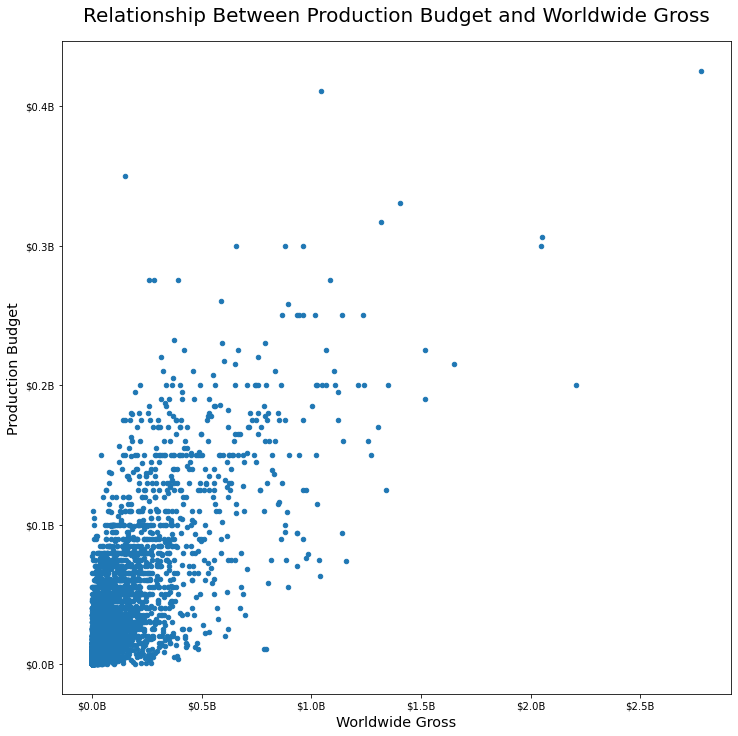

In [31]:
ax = movie_budget_pop.plot.scatter('worldwide_gross', 'production_budget', figsize=(12,12))

ax.set_title('Relationship Between Production Budget and Worldwide Gross',pad=20, fontsize=20)
ax.set_xlabel('Worldwide Gross', fontsize='x-large')
ax.set_ylabel('Production Budget', fontsize='x-large')
formatter = FuncFormatter(billions)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

- Budget & gross profit have positive relationship

6. find average movie budget, profit and profit ratio

In [16]:
average_set = movie_budget_pop.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].mean()

<ipython-input-16-9b2269025376>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_set = movie_budget_pop.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].mean()


In [17]:
average_set

,production_budget,worldwide_gross
year,,
1915,1.100000e+05,1.100000e+07
1916,2.000000e+05,8.000000e+06
1920,1.000000e+05,3.000000e+06
1925,2.072500e+06,1.550000e+07
1929,3.790000e+05,4.358000e+06
...,...,...
2015,3.570830e+07,1.161149e+08
2016,4.400230e+07,1.407414e+08
2017,5.009202e+07,1.720271e+08


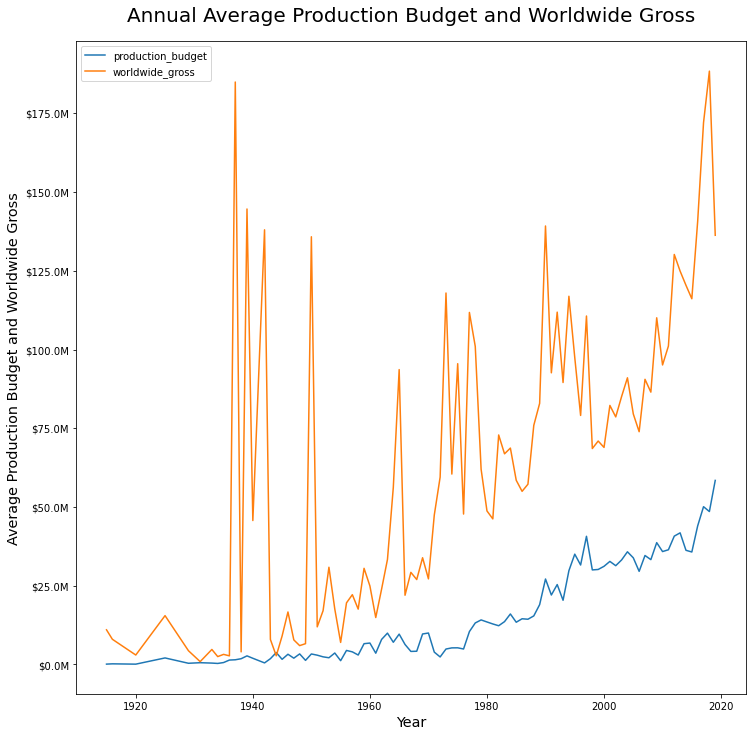

In [18]:
ax = average_set.plot(figsize=(12,12))


ax.set_title('Annual Average Production Budget and Worldwide Gross',pad=20, fontsize=20)
ax.set_xlabel('Year', fontsize='x-large')
ax.set_ylabel('Average Production Budget and Worldwide Gross', fontsize='x-large')
formatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter);

- Budget and gross profit grow over the time

7. make new dataframe without 'studio' NaN values

In [19]:
# drop 'studio' NaN values' rows 
new_set = movie_budget_pop.dropna(subset=['studio'])
new_set = movie_budget_pop[movie_budget_pop['year'] >= 2010]
new_set = new_set[new_set['year'] < 2019]




In [20]:
# make year_count dataframe by using groupby
year_count = new_set.groupby(['year'], sort=True)['production_budget'].count()
year_sum = new_set.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].sum()
year_sum['number of movies'] = year_count

<ipython-input-20-7f5bb5edc5be>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  year_sum = new_set.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].sum()


In [21]:
year_sum

,production_budget,worldwide_gross,number of movies
year,,,
2010,9.355366e+09,2.482039e+10,261
2011,8.921685e+09,2.476813e+10,245
2012,8.474829e+09,2.707662e+10,208
2013,8.817485e+09,2.635116e+10,211
2014,7.575910e+09,2.516035e+10,209
2015,8.641408e+09,2.809981e+10,242
2016,8.976470e+09,2.871124e+10,204
2017,8.265183e+09,2.838448e+10,165
2018,6.700050e+09,2.599667e+10,138


8. Check total production budget, worldwide gross, total number of movies

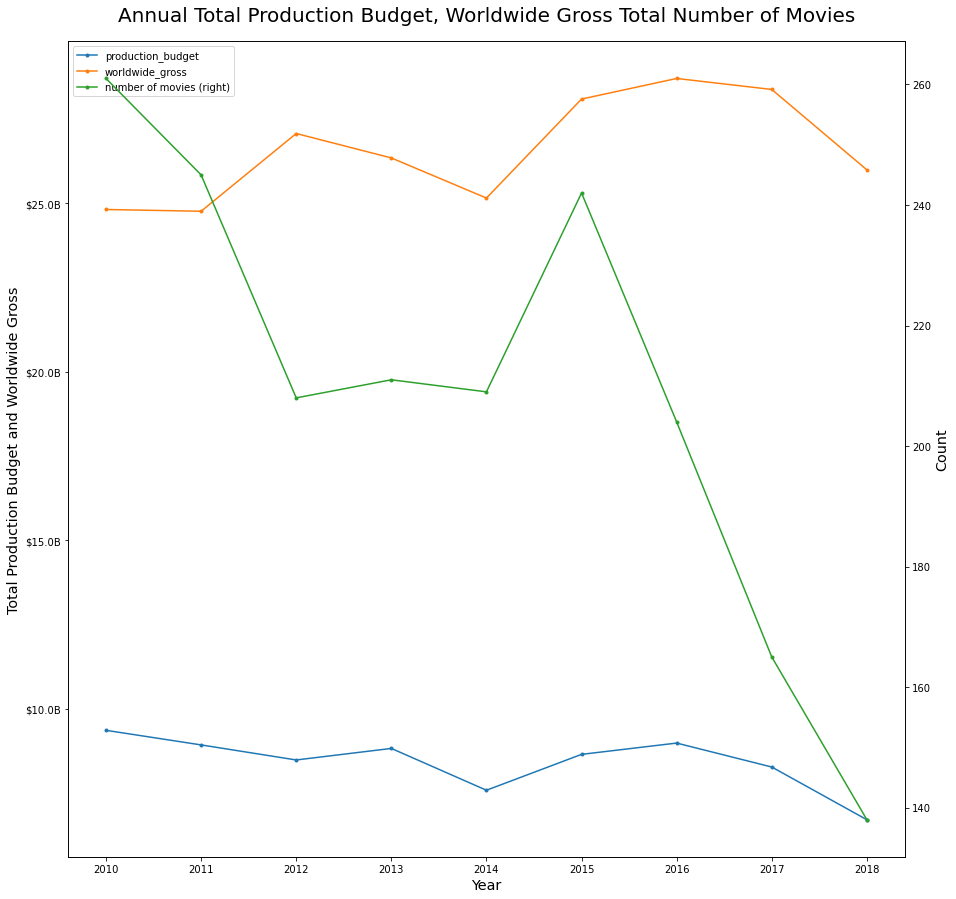

In [22]:
ax = year_sum.plot(figsize=(15,15), secondary_y=['number of movies'], marker='.')


ax.set_title("Annual Total Production Budget, Worldwide Gross Total Number of Movies", pad=20, fontsize=20)
ax.set_xlabel('Year', fontsize='x-large')
ax.set_ylabel('Total Production Budget and Worldwide Gross', fontsize='x-large')
ax.right_ax.set_ylabel('Count', fontsize='x-large')
formatter = FuncFormatter(billions)
ax.yaxis.set_major_formatter(formatter);

profit increased and budget is almost same but number of movies decreased

9. make dataframe which explain studio's annual data

In [23]:
year_studio_sum = movie_budget_pop.groupby(['studio','year'], sort=True)['production_budget', 'worldwide_gross'].sum()
year_studio_count = movie_budget_pop.groupby(['studio','year'], sort=True)['production_budget'].count()
year_studio_sum['number of movies'] = year_studio_count

year_studio_sum = year_studio_sum.reset_index()
year_studio_sum = year_studio_sum[year_studio_sum['year'] >= 2010]
year_studio_sum = year_studio_sum[year_studio_sum['year'] < 2019]
year_studio_sum= year_studio_sum.set_index('year')


<ipython-input-23-c5d1e1793fb4>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  year_studio_sum = movie_budget_pop.groupby(['studio','year'], sort=True)['production_budget', 'worldwide_gross'].sum()


In [24]:
# find top 30 worldwide gross of year_studio_sum's studio name
top35_year_studio_sum = year_studio_sum.nlargest(35, ['worldwide_gross'])
list_top35_year_studio_sum = list(set(top35_year_studio_sum['studio']))
print(list_top35_year_studio_sum)

['Sony', 'Fox', 'Disney', 'Paramount Pictures', 'Universal Studios', 'Warner Bros']


10. average values of major 6 studios's, period: 9years

In [25]:
year_studio_sum[year_studio_sum['studio'].isin(list_top35_year_studio_sum)].mean().astype(str)

production_budget     859632962.962963
worldwide_gross      3046739550.314815
number of movies     11.88888888888889
dtype: object

11. compare major and non-major studio's data

In [28]:
# grouping and cleaning data

movie_budget_pop_2010 = movie_budget_pop[movie_budget_pop['year'] >= 2010]
movie_budget_pop_2010 = movie_budget_pop_2010[movie_budget_pop_2010['year'] < 2019]

major_studio_data = movie_budget_pop_2010[movie_budget_pop_2010.studio.isin(list_top35_year_studio_sum)]
major_studio_data = major_studio_data.drop_duplicates()

major_year_count = major_studio_data.groupby(['year'], sort=True)['production_budget'].count()
major_year_sum = major_studio_data.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].sum()
major_year_sum['number of movies'] = major_year_count



non_major_studio_data = movie_budget_pop_2010[~movie_budget_pop_2010.studio.isin(list_top35_year_studio_sum)]
non_major_studio_data = non_major_studio_data.drop_duplicates()


non_major_year_count = non_major_studio_data.groupby(['year'], sort=True)['production_budget'].count()
non_major_year_sum = non_major_studio_data.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].sum()
non_major_year_sum['number of movies'] = non_major_year_count

studio_data = major_year_sum.join(non_major_year_sum, how='outer', lsuffix='_major', rsuffix='_non_major')
studio_data = studio_data.dropna()

<ipython-input-28-612815ac4434>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  major_year_sum = major_studio_data.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].sum()
<ipython-input-28-612815ac4434>:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  non_major_year_sum = non_major_studio_data.groupby(['year'], sort=True)['production_budget', 'worldwide_gross'].sum()


In [29]:
studio_data

,production_budget_major,worldwide_gross_major,number of movies_major,production_budget_non_major,worldwide_gross_non_major,number of movies_non_major
year,,,,,,
2010,5.069470e+09,1.503071e+10,79,4.285896e+09,9.789678e+09,182
2011,5.405375e+09,1.600862e+10,86,3.516310e+09,8.759514e+09,159
2012,5.097935e+09,1.678920e+10,72,3.376894e+09,1.028742e+10,136
2013,5.576500e+09,1.794241e+10,69,3.240985e+09,8.408743e+09,142
2014,4.595300e+09,1.727388e+10,66,2.980610e+09,7.886472e+09,143
2015,5.652700e+09,2.130535e+10,83,2.988708e+09,6.794465e+09,159
2016,5.310000e+09,1.963480e+10,71,3.666470e+09,9.076445e+09,133
2017,5.451500e+09,2.137669e+10,61,2.813683e+09,7.007785e+09,104
2018,4.261400e+09,1.916228e+10,55,2.438650e+09,6.834384e+09,83


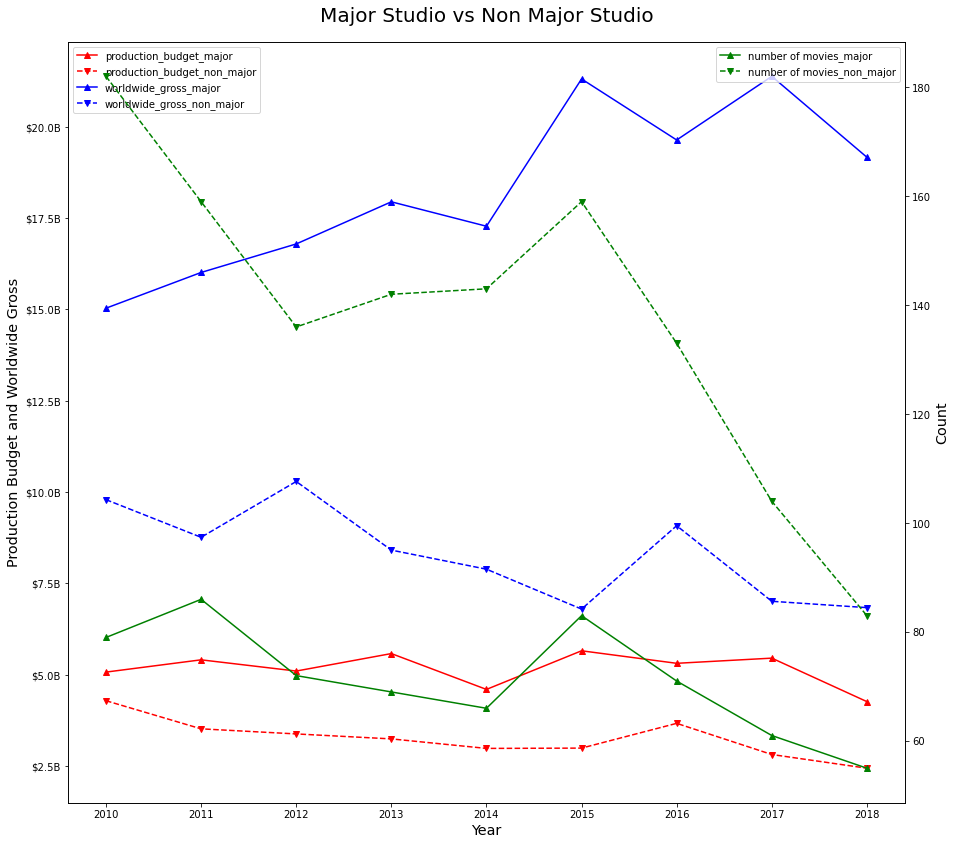

In [30]:
fig, ax = plt.subplots(figsize=(15,14))

ax.plot(studio_data.index, studio_data['production_budget_major'], 'r', marker="^", label = 'production_budget_major')
ax.plot(studio_data.index, studio_data['production_budget_non_major'], 'r--', marker="v", label = 'production_budget_non_major')
plt.legend()


ax.plot(studio_data.index, studio_data['worldwide_gross_major'], 'b', marker="^", label = 'worldwide_gross_major')
ax.plot(studio_data.index, studio_data['worldwide_gross_non_major'], 'b--', marker="v", label = 'worldwide_gross_non_major')
ax.set_xlabel('Year', fontsize='x-large')
ax.set_ylabel('Production Budget and Worldwide Gross', fontsize='x-large')
formatter = FuncFormatter(billions)
ax.yaxis.set_major_formatter(formatter)
plt.legend()


ax2 = ax.twinx()
ax2.plot(studio_data.index, studio_data['number of movies_major'], 'g', marker="^", label = 'number of movies_major')
ax2.plot(studio_data.index, studio_data['number of movies_non_major'], 'g--', marker="v", label = 'number of movies_non_major')
ax2.set_ylabel('Count', fontsize='x-large')

plt.title('Major Studio vs Non Major Studio', pad=20, fontsize=20)


plt.legend()
plt.show()

12. drow plots of top 30 worldwide gross of year_studio_sum's studio data
- Q: how to set secondary yticks, x label of first row

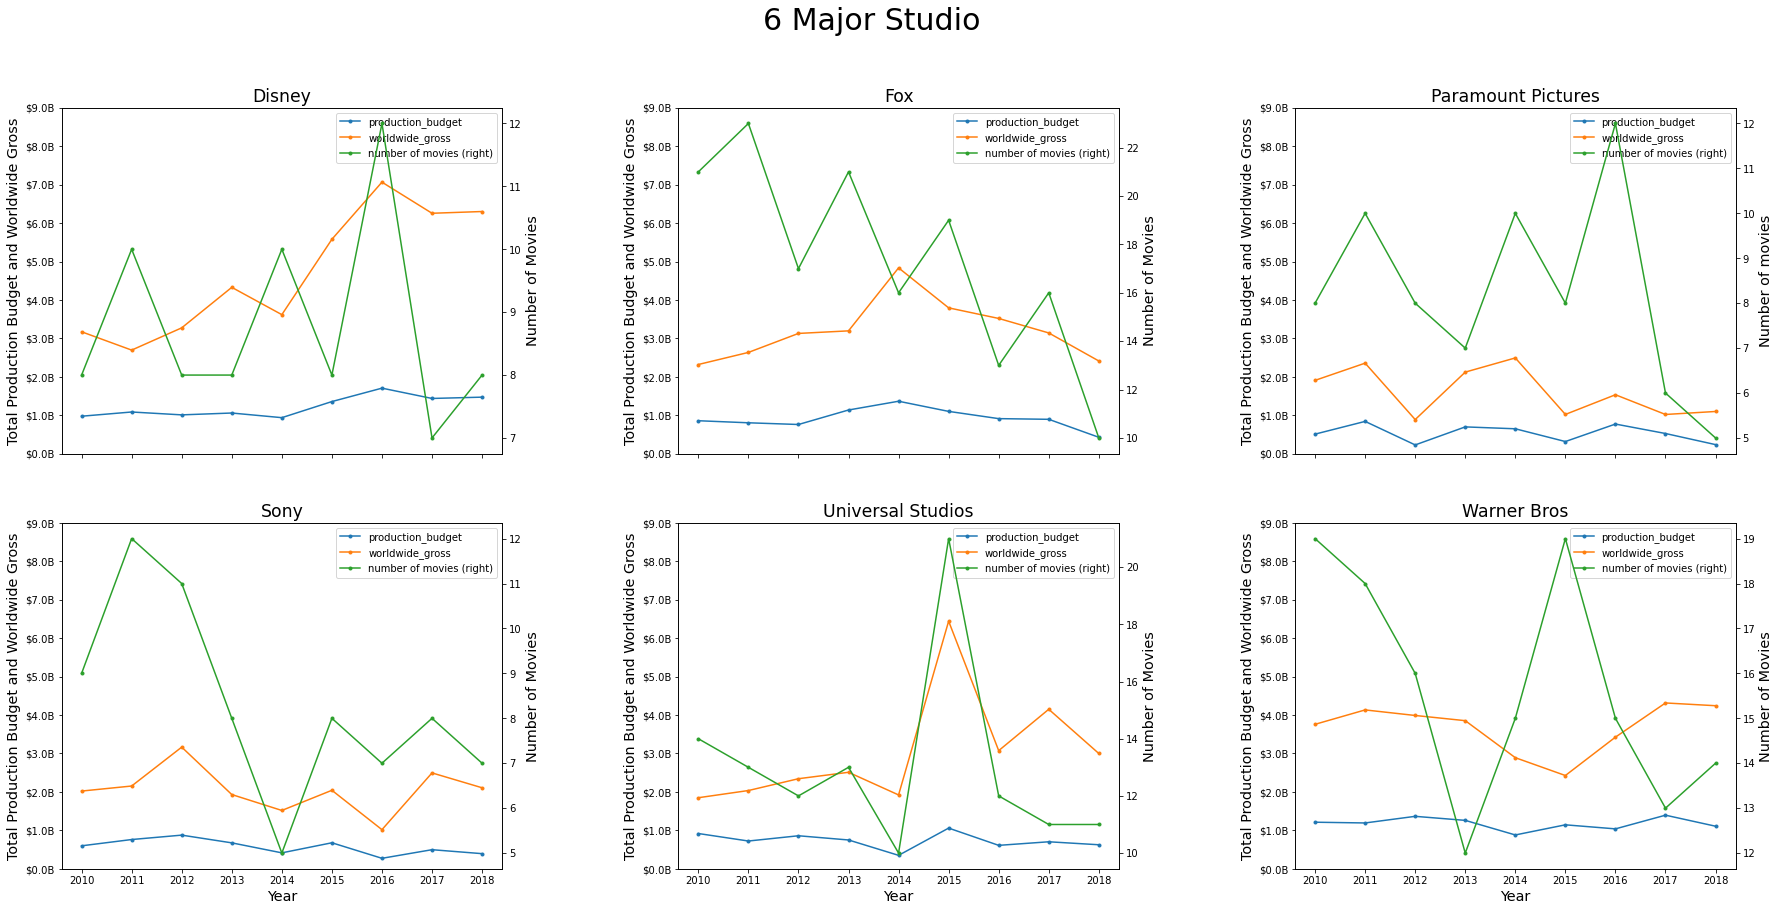

In [282]:
fig, axes = plt.subplots(2,3, figsize=(30,14))
fig.subplots_adjust(wspace=.4)
fig.suptitle("6 Major Studio", fontsize=30)

formatter = FuncFormatter(billions)


#axes.set_title = ('Top 6 Studio Budget, Profit, Number of Movies')

year_studio_sum[year_studio_sum['studio']=='Disney'].plot(ax=axes[0,0], yticks=np.arange(0, 10000000000, 1000000000), secondary_y=['number of movies'], marker='.')
axes[0, 0].set_title('Disney', fontsize='xx-large')
axes[0, 0].set_xlabel('Year', fontsize='x-large')
axes[0, 0].set_ylabel('Total Production Budget and Worldwide Gross', fontsize='x-large')
axes[0, 0].right_ax.set_ylabel('Number of Movies', fontsize='x-large')
axes[0, 0].yaxis.set_major_formatter(formatter)


year_studio_sum[year_studio_sum['studio']=='Fox'].plot(ax=axes[0,1], yticks=np.arange(0, 10000000000, 1000000000), secondary_y=['number of movies'], marker='.')
axes[0, 1].set_title('Fox', fontsize='xx-large')
axes[0, 1].set_xlabel('Year', fontsize='x-large')
axes[0, 1].set_ylabel('Total Production Budget and Worldwide Gross', fontsize='x-large')
axes[0, 1].right_ax.set_ylabel('Number of Movies', fontsize='x-large')
axes[0, 1].yaxis.set_major_formatter(formatter)


year_studio_sum[year_studio_sum['studio']=='Paramount Pictures'].plot(ax=axes[0,2], yticks=np.arange(0, 10000000000, 1000000000), secondary_y=['number of movies'], marker='.')
axes[0, 2].set_title('Paramount Pictures', fontsize='xx-large')
axes[0, 2].set_xlabel('Year', fontsize='x-large')
axes[0, 2].set_ylabel('Total Production Budget and Worldwide Gross', fontsize='x-large')
axes[0, 2].right_ax.set_ylabel('Number of movies', fontsize='x-large')
axes[0, 2].yaxis.set_major_formatter(formatter)


year_studio_sum[year_studio_sum['studio']=='Sony'].plot(ax=axes[1,0], yticks=np.arange(0, 10000000000, 1000000000), secondary_y=['number of movies'], marker='.')
axes[1, 0].set_title('Sony', fontsize='xx-large')
axes[1, 0].set_xlabel('Year', fontsize='x-large')
axes[1, 0].set_ylabel('Total Production Budget and Worldwide Gross', fontsize='x-large')
axes[1, 0].right_ax.set_ylabel('Number of Movies', fontsize='x-large')
axes[1, 0].yaxis.set_major_formatter(formatter)


year_studio_sum[year_studio_sum['studio']=='Universal Studios'].plot(ax=axes[1,1], yticks=np.arange(0, 10000000000, 1000000000), secondary_y=['number of movies'], marker='.')
axes[1, 1].set_title('Universal Studios', fontsize='xx-large')
axes[1, 1].set_xlabel('Year', fontsize='x-large')
axes[1, 1].set_ylabel('Total Production Budget and Worldwide Gross', fontsize='x-large')
axes[1, 1].right_ax.set_ylabel('Number of Movies', fontsize='x-large')
axes[1, 1].yaxis.set_major_formatter(formatter)


year_studio_sum[year_studio_sum['studio']=='Warner Bros'].plot(ax=axes[1,2], yticks=np.arange(0, 10000000000, 1000000000), secondary_y=['number of movies'], marker='.')
axes[1, 2].set_title('Warner Bros', fontsize='xx-large')
axes[1, 2].set_xlabel('Year', fontsize='x-large')
axes[1, 2].set_ylabel('Total Production Budget and Worldwide Gross', fontsize='x-large')
axes[1, 2].right_ax.set_ylabel('Number of Movies', fontsize='x-large');
axes[1, 2].yaxis.set_major_formatter(formatter)
